## Интеллектуальный анализ данных – весна 2021
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html). 

Загрузим набор данных и сохраним информацию о признаках в переменную `x`, а о зависимой переменной – в переменную `y`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
from sklearn.datasets import load_wine

data = load_wine()
x = pd.DataFrame(data['data'], columns=data['feature_names'])
y = data['target']
x.head(8)

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   
5    14.20        1.76  2.45               15.2      112.0           3.27   
6    14.39        1.87  2.45               14.6       96.0           2.50   
7    14.06        2.15  2.61               17.6      121.0           2.60   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   
5        3.39                  0.34             1.97             6.75  1.05   
6        2.52                  0.30             1.98             5.25  1.02   
7        2.51                  0.31             1.25             5.05  1.06   

   od280/od315_of_diluted_wines  proline  
0                          3.92   1065.0  
1                          3.40   1050.0  
2                          3.17   1185.0  
3                          3.45   1480.0  
4                          2.93    735.0  
5                          2.85   1450.0  
6                          3.58   1290.0  
7                          3.58   1295.0

**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования.

In [3]:
x.isna().sum().to_frame('n/a count').T  # No missing values

alcohol  malic_acid  ash  alcalinity_of_ash  magnesium  \
n/a count        0           0    0                  0          0   

           total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
n/a count              0           0                     0                0   

           color_intensity  hue  od280/od315_of_diluted_wines  proline  
n/a count                0    0                             0        0

In [4]:
x.agg(['dtypes', 'nunique', 'count'])  # No categorical variables

alcohol malic_acid      ash alcalinity_of_ash magnesium  \
dtypes   float64    float64  float64           float64   float64   
nunique      126        133       79                63        53   
count        178        178      178               178       178   

        total_phenols flavanoids nonflavanoid_phenols proanthocyanins  \
dtypes        float64    float64              float64         float64   
nunique            97        132                   39             101   
count             178        178                  178             178   

        color_intensity      hue od280/od315_of_diluted_wines  proline  
dtypes          float64  float64                      float64  float64  
nunique             132       78                          122      121  
count               178      178                          178      178

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

In [5]:
from sklearn.model_selection import train_test_split

np.random.seed(228)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [6]:
from sklearn.preprocessing import StandardScaler

features = ['alcohol', 'magnesium']

scaler = StandardScaler()
x_train_prepared = scaler.fit_transform(x_train[features], None)
x_test_prepared = scaler.transform(x_test[features])

x_train_prepared.mean(), x_train_prepared.std()  # mean is 0, std is 1

(4.1257320140909046e-15, 0.9999999999999998)

In [7]:
from sklearn.neighbors import KNeighborsClassifier


def fit_and_score(model):
    # x_train_prepared and y_train are globals
    model.fit(x_train_prepared, y_train)
    return model.score(x_test_prepared, y_test)


ks = 1, 3, 5, 10, 15, 25
knn_models = [KNeighborsClassifier(k) for k in ks]
accuracy_scores = map(fit_and_score, knn_models)

k_index = pd.Index(ks, name='k')
pd.DataFrame(accuracy_scores, index=k_index, columns=['accuracy'])

accuracy
k           
1   0.555556
3   0.611111
5   0.666667
10  0.740741
15  0.685185
25  0.685185

**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](https://rasbt.github.io/mlxtend/installation/). 

In [8]:
!pip install mlxtend

Defaulting to user installation because normal site-packages is not writeable


Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [9]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](https://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов. 
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `x_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново. 
6. Построение графика может занять некоторое время – придётся немного подождать!

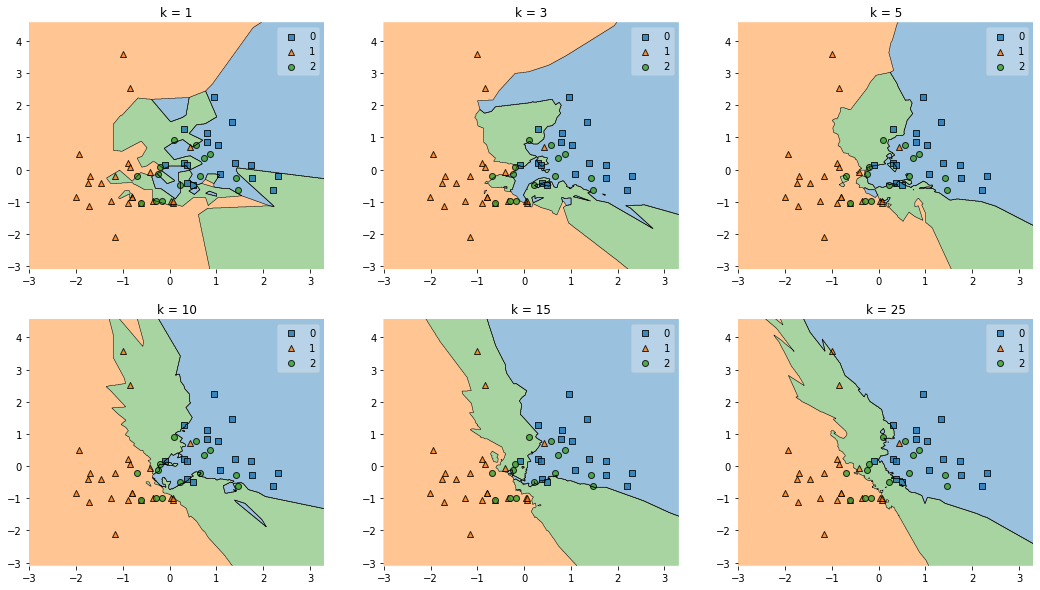

In [10]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from mlxtend.plotting import plot_decision_regions

w, h = 3, 2
grid = gridspec.GridSpec(h, w)
plt.figure(figsize=(6 * w, 5 * h))

for i, clf in enumerate(knn_models):
    plt.subplot(grid[i // w, i % w])
    plot_decision_regions(x_test_prepared, y_test, clf)
    plt.title(f'k = {clf.n_neighbors}')

plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности.

_Давайте остановимся на $k = 10$._

### Задание 2: Обученная машина.

В этом задании мы рассмотрим упрощённую идею того, как метод ближайших соседей можно применить при моделировании движения робота. 

Рассмотрим робота на дискретной двумерной плоскости, который за каждый момент дискретного времени может передвинуться на одну позицию вправо, влево, вверх или вниз. На плоскости разбросаны метки одного из четырёх классов, анализируя которые робот может (но не обязан) корректировать своё перемещение. Пусть метки класса 0 соответствуют сигналу переместиться вправо, метки класса 1 – влево, класса 2 – вверх, класса 3 – вниз. 

Передвижение робота осуществляется по следующему правилу: с вероятностью 0.2 робот передвинется вправо, и с вероятностью 0.8 – оценит, метки какого класса преобладают среди `k` его ближайших соседей, и передвинется в направлении этого доминирующего класса. 

Для лучшего понимания происходящего изобразим возможное положение робота и меток:

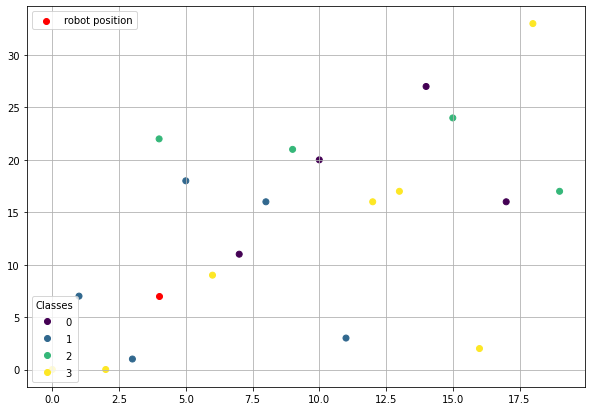

In [11]:
np.random.seed(12345)
x = np.arange(20)
landmarks = x + np.round(np.random.normal(2, 8, 20)) # сгенерируем случайные метки
random_classes = np.random.randint(0, 4, 20)

fig, ax = plt.subplots(figsize = (10, 7))
scatter = ax.scatter(x, landmarks, c = random_classes)
ax.scatter(4, 7, c = 'r', marker = 'o', label = 'robot position')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc = "lower left", title = "Classes")
ax.add_artist(legend1)

plt.plot()
_ = plt.legend()
_ = plt.grid()

На следующем шаге робот передвинется на 1 либо вправо, либо в направлении, которое указывают ближайшие соседи.

**Задача 2.1 (1.5 балла)** Реализуйте класс, который задаёт описанное поведение робота, используя шаблон ниже:
1. Определите атрибуты `trajectory` (переменная для хранения истории перемещения робота в виде последовательности точек с двумя координатами) и `knn` (обученный kNN классификатор, который по позиции метки предсказывает её класс).
2. Определите метод `move()`: рассчитайте новое положение робота по правилам выше и добавьте её в историю перемещений. Подсказка: исходы можно интерпретировать как результаты подбрасывания монетки с вероятностью орла, равной 0.2. Для моделирования такого подбрасывания можно использовать, например, `np.random.binomial()` с правильными параметрами. 

In [12]:
from sklearn.neighbors import KNeighborsClassifier

In [13]:
class MobileRobot():
    right = np.array([ 1,  0])
    left  = np.array([-1,  0])
    up    = np.array([ 0,  1])
    down  = np.array([ 0, -1])
    
    mapping = {0: right,
               1: left,
               2: up,
               3: down}
    
    def __init__(self, k, initial_position, landmarks, classes):
        self.trajectory = [initial_position]
        self.knn = KNeighborsClassifier(k)
        self.knn.fit(landmarks, classes)
        
    def move(self):
        pos = self.trajectory[-1]
        
        if np.random.binomial(1, 0.2):
            go = self.right
        else:
            pred = self.knn.predict([pos])
            go = self.mapping[pred[0]]
            
        self.trajectory.append(pos + go)

**Задача 2.2 (0.5 балла)** Дополните функцию `conduct_experiment`: определите переменную `traj` так, чтобы она содержала историю перемещения робота в виде двумерного массива numpy, в котором столбцы соответствуют координатам x и y соответствующей позиции.

In [14]:
def conduct_experiment(x,
                       mean=0,
                       std=2,
                       n_movements=10,
                       k=3,
                       initial_position=np.array([10, 20])):
    
    np.random.seed(12345)
    
    landmarks = np.vstack((x, x + np.round(np.random.normal(mean, std, len(x))))).T
    classes = np.random.randint(0, 4, size=len(x))
    
    robot = MobileRobot(k, initial_position, landmarks, classes)
    for n in range(n_movements):
        robot.move()
    
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(landmarks[:, 0], landmarks[:, 1], c=classes)
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="classes")
    ax.add_artist(legend1)
    
    traj = np.array(robot.trajectory)
    ax.plot(traj[:, 0], traj[:, 1], 
               c='r', marker='o', label='robot position')

    plt.plot()
    plt.legend()
    plt.grid()

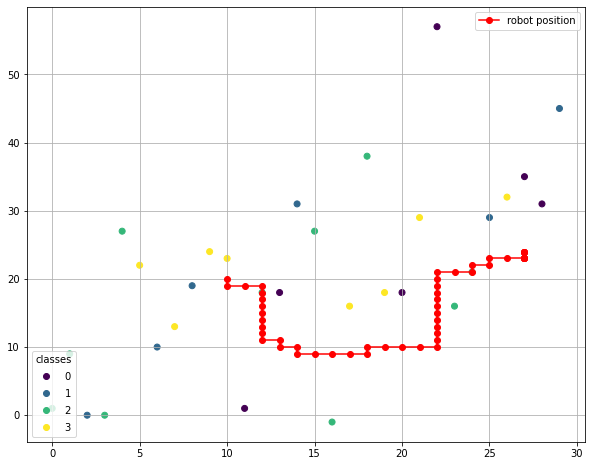

In [15]:
experiment_params = dict(mean=3, std=10, n_movements=50)
x = np.arange(30)

conduct_experiment(x, k=5, **experiment_params)

**Задача 2.3 (1 балл)** Как число соседей влияет на траекторию движения робота в нашем эксперименте? Постройте четыре графика с различным числом соседей на ваш выбор. А что было бы в случае, если классы назначаются меткам не случайно, а осмысленно? 

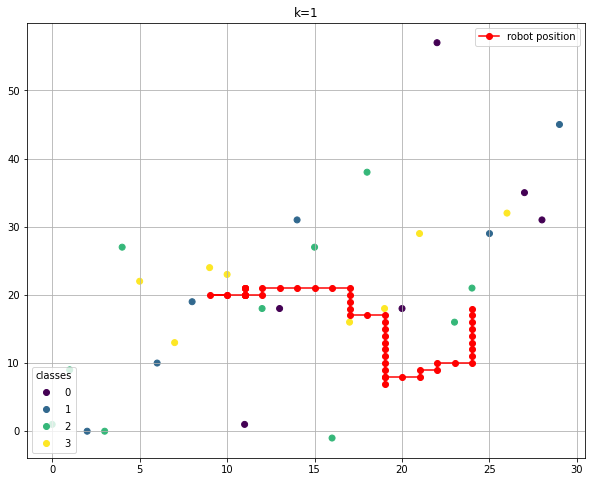

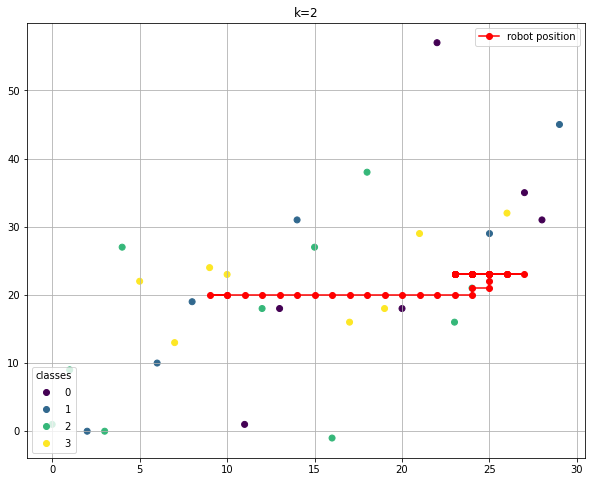

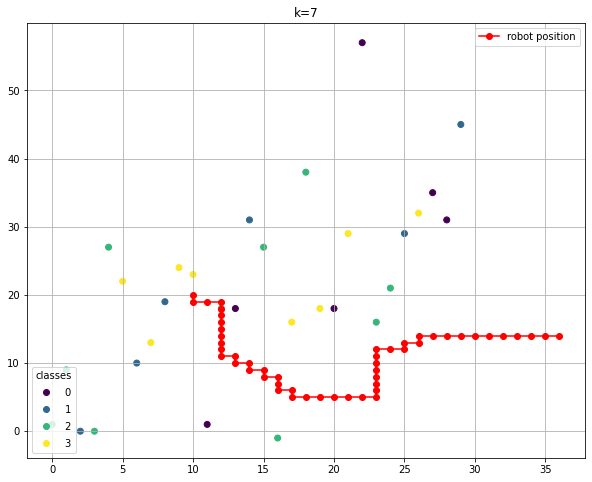

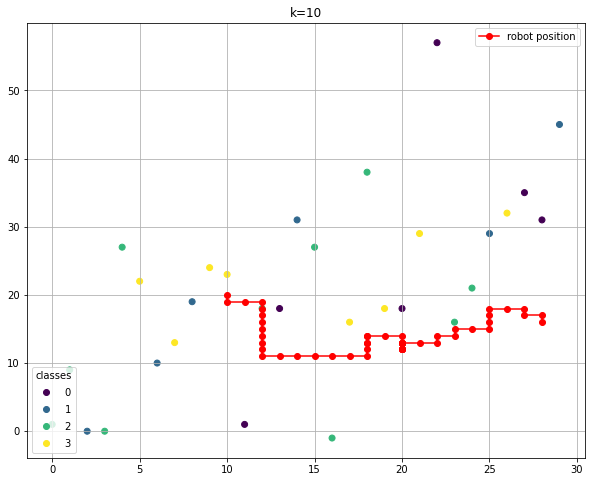

In [16]:
for k in (1, 2, 7, 10):
    conduct_experiment(x, k=k, **experiment_params)
    plt.title(f'{k=}')

_Честно говоря, вообще без понятия, как количество соседей влияет на траекторию движения, но каким-то образом явно влияет._

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [17]:
data = pd.read_csv('hw04-knn-linreg-data/diamonds.csv')
data.head(5)

Unnamed: 0  carat      cut color clarity  depth  table  price     x     y  \
0           1   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98   
1           2   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84   
2           3   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07   
3           4   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23   
4           5   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35   

      z  
0  2.43  
1  2.31  
2  2.31  
3  2.63  
4  2.75

Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.1 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их. 

In [18]:
data.isna().sum().to_frame('n/a count')

n/a count
Unnamed: 0          0
carat               0
cut                 0
color               0
clarity             0
depth               0
table               0
price               0
x                   0
y                   0
z                   0

**Задача 3.2 (0.1 балла)** Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [19]:
junk = ['Unnamed: 0']

data = data.drop(columns=junk, errors='ignore')
data

carat        cut color clarity  depth  table  price     x     y     z
0       0.23      Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1       0.21    Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2       0.23       Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3       0.29    Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4       0.31       Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
...      ...        ...   ...     ...    ...    ...    ...   ...   ...   ...
53935   0.72      Ideal     D     SI1   60.8   57.0   2757  5.75  5.76  3.50
53936   0.72       Good     D     SI1   63.1   55.0   2757  5.69  5.75  3.61
53937   0.70  Very Good     D     SI1   62.8   60.0   2757  5.66  5.68  3.56
53938   0.86    Premium     H     SI2   61.0   58.0   2757  6.15  6.12  3.74
53939   0.75      Ideal     D     SI2   62.2   55.0   2757  5.83  5.87  3.64

[53940 rows x 10 columns]

**Задача 3.3 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [20]:
data.corr()

carat     depth     table     price         x         y         z
carat  1.000000  0.028224  0.181618  0.921591  0.975094  0.951722  0.953387
depth  0.028224  1.000000 -0.295779 -0.010647 -0.025289 -0.029341  0.094924
table  0.181618 -0.295779  1.000000  0.127134  0.195344  0.183760  0.150929
price  0.921591 -0.010647  0.127134  1.000000  0.884435  0.865421  0.861249
x      0.975094 -0.025289  0.195344  0.884435  1.000000  0.974701  0.970772
y      0.951722 -0.029341  0.183760  0.865421  0.974701  1.000000  0.952006
z      0.953387  0.094924  0.150929  0.861249  0.970772  0.952006  1.000000

**Задача 3.4 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [21]:
cat = ['cut', 'color', 'clarity']
data[cat] = data[cat].astype('category')

# dummies = pd.get_dummies(data[cat])
# data[dummies.columns] = dummies

data = pd.get_dummies(data, columns=cat)
data

carat  depth  table  price     x     y     z  cut_Fair  cut_Good  \
0       0.23   61.5   55.0    326  3.95  3.98  2.43         0         0   
1       0.21   59.8   61.0    326  3.89  3.84  2.31         0         0   
2       0.23   56.9   65.0    327  4.05  4.07  2.31         0         1   
3       0.29   62.4   58.0    334  4.20  4.23  2.63         0         0   
4       0.31   63.3   58.0    335  4.34  4.35  2.75         0         1   
...      ...    ...    ...    ...   ...   ...   ...       ...       ...   
53935   0.72   60.8   57.0   2757  5.75  5.76  3.50         0         0   
53936   0.72   63.1   55.0   2757  5.69  5.75  3.61         0         1   
53937   0.70   62.8   60.0   2757  5.66  5.68  3.56         0         0   
53938   0.86   61.0   58.0   2757  6.15  6.12  3.74         0         0   
53939   0.75   62.2   55.0   2757  5.83  5.87  3.64         0         0   

       cut_Ideal  cut_Premium  cut_Very Good  color_D  color_E  color_F  \
0              1            0              0        0        1        0   
1              0            1              0        0        1        0   
2              0            0              0        0        1        0   
3              0            1              0        0        0        0   
4              0            0              0        0        0        0   
...          ...          ...            ...      ...      ...      ...   
53935          1            0              0        1        0        0   
53936          0            0              0        1        0        0   
53937          0            0              1        1        0        0   
53938          0            1              0        0        0        0   
53939          1            0              0        1        0        0   

       color_G  color_H  color_I  color_J  clarity_I1  clarity_IF  \
0            0        0        0        0           0           0   
1            0        0        0        0           0           0   
2            0        0        0        0           0           0   
3            0        0        1        0           0           0   
4            0        0        0        1           0           0   
...        ...      ...      ...      ...         ...         ...   
53935        0        0        0        0           0           0   
53936        0        0        0        0           0           0   
53937        0        0        0        0           0           0   
53938        0        1        0        0           0           0   
53939        0        0        0        0           0           0   

       clarity_SI1  clarity_SI2  clarity_VS1  clarity_VS2  clarity_VVS1  \
0                0            1            0            0             0   
1                1            0            0            0             0   
2                0            0            1            0             0   
3                0            0            0            1             0   
4                0            1            0            0             0   
...            ...          ...          ...          ...           ...   
53935            1            0            0            0             0   
53936            1            0            0            0             0   
53937            1            0            0            0             0   
53938            0            1            0            0             0   
53939            0            1            0            0             0   

       clarity_VVS2  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
53935             0  
53936             0  
53937             0  
53938             0  
53939             0  

[53940 rows x 27 columns]

In [22]:
# Не будем кодировать переменные, как порядковые
# (Хотя очень хотелось)

orders = {
    'cut': ('Fair', 'Good', 'Very Good', 'Premium', 'Ideal'),
    'color': ('J', 'I', 'H', 'G', 'F', 'E', 'D'),
    'clarity': ('I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'),
}

mappers = {
    col: {v: i for i, v in enumerate(values)}
    for col, values in orders.items()
}

# data = data.replace(mappers)
# data

**Задача 3.5 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3.

In [23]:
target = 'price'

x = data.drop(columns=target)
y = data[target]

x

carat  depth  table     x     y     z  cut_Fair  cut_Good  cut_Ideal  \
0       0.23   61.5   55.0  3.95  3.98  2.43         0         0          1   
1       0.21   59.8   61.0  3.89  3.84  2.31         0         0          0   
2       0.23   56.9   65.0  4.05  4.07  2.31         0         1          0   
3       0.29   62.4   58.0  4.20  4.23  2.63         0         0          0   
4       0.31   63.3   58.0  4.34  4.35  2.75         0         1          0   
...      ...    ...    ...   ...   ...   ...       ...       ...        ...   
53935   0.72   60.8   57.0  5.75  5.76  3.50         0         0          1   
53936   0.72   63.1   55.0  5.69  5.75  3.61         0         1          0   
53937   0.70   62.8   60.0  5.66  5.68  3.56         0         0          0   
53938   0.86   61.0   58.0  6.15  6.12  3.74         0         0          0   
53939   0.75   62.2   55.0  5.83  5.87  3.64         0         0          1   

       cut_Premium  cut_Very Good  color_D  color_E  color_F  color_G  \
0                0              0        0        1        0        0   
1                1              0        0        1        0        0   
2                0              0        0        1        0        0   
3                1              0        0        0        0        0   
4                0              0        0        0        0        0   
...            ...            ...      ...      ...      ...      ...   
53935            0              0        1        0        0        0   
53936            0              0        1        0        0        0   
53937            0              1        1        0        0        0   
53938            1              0        0        0        0        0   
53939            0              0        1        0        0        0   

       color_H  color_I  color_J  clarity_I1  clarity_IF  clarity_SI1  \
0            0        0        0           0           0            0   
1            0        0        0           0           0            1   
2            0        0        0           0           0            0   
3            0        1        0           0           0            0   
4            0        0        1           0           0            0   
...        ...      ...      ...         ...         ...          ...   
53935        0        0        0           0           0            1   
53936        0        0        0           0           0            1   
53937        0        0        0           0           0            1   
53938        1        0        0           0           0            0   
53939        0        0        0           0           0            0   

       clarity_SI2  clarity_VS1  clarity_VS2  clarity_VVS1  clarity_VVS2  
0                1            0            0             0             0  
1                0            0            0             0             0  
2                0            1            0             0             0  
3                0            0            1             0             0  
4                1            0            0             0             0  
...            ...          ...          ...           ...           ...  
53935            0            0            0             0             0  
53936            0            0            0             0             0  
53937            0            0            0             0             0  
53938            1            0            0             0             0  
53939            1            0            0             0             0  

[53940 rows x 26 columns]

In [24]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((37758, 26), (16182, 26), (37758,), (16182,))

**Задача 3.6 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_std = scaler.fit_transform(x_train)
x_test_std = scaler.transform(x_test)

print('Train mu & sigma:', (x_train_std.mean(), x_train_std.std()))
print('Test mu & sigma:', (x_test_std.mean(), x_test_std.std()))

Train mu & sigma: (2.918181097815603e-16, 1.0)
Test mu & sigma: (-0.0013138606510195295, 1.0004354974010412)


**Задача 3.7 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lrm = LinearRegression()
lrm.fit(x_train_std, y_train)

y_train_pred = lrm.predict(x_train_std)
y_test_pred = lrm.predict(x_test_std)

print('Train MSE:', mean_squared_error(y_train, y_train_pred))
print('Train R2:', r2_score(y_train, y_train_pred))

print('Test MSE:', mean_squared_error(y_test, y_test_pred))
print('Test R2:', r2_score(y_test, y_test_pred))

Train MSE: 1290560.0569167936
Train R2: 0.9195964965187933
Test MSE: 1244727.133241059
Test R2: 0.9201891473611479


**Задача 3.8 (0.2 балла)** Изучите документацию модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [27]:
def get_coef_frame(model):
    coef = pd.DataFrame(zip(model.coef_, abs(model.coef_)),
                        columns=['coef', 'abs. coef'], index=x.columns)

    return coef.sort_values('abs. coef', ascending=False).T

In [28]:
get_coef_frame(lrm)

cut_Ideal   cut_Premium  cut_Very Good      cut_Good  \
coef      -2.699863e+15 -2.404806e+15  -2.304292e+15 -1.579481e+15   
abs. coef  2.699863e+15  2.404806e+15   2.304292e+15  1.579481e+15   

               cut_Fair   clarity_SI1   clarity_VS2   clarity_SI2  \
coef      -9.365999e+14 -7.393454e+14 -7.214043e+14 -6.452539e+14   
abs. coef  9.365999e+14  7.393454e+14  7.214043e+14  6.452539e+14   

            clarity_VS1  clarity_VVS2  clarity_VVS1    clarity_IF  \
coef      -6.172232e+14 -5.001112e+14 -4.334928e+14 -3.077026e+14   
abs. coef  6.172232e+14  5.001112e+14  4.334928e+14  3.077026e+14   

             clarity_I1       color_G       color_E       color_F  \
coef      -1.992557e+14  5.386229e+13  5.117836e+13  5.080585e+13   
abs. coef  1.992557e+14  5.386229e+13  5.117836e+13  5.080585e+13   

                color_H       color_D       color_I       color_J  \
coef       4.813873e+13  4.393958e+13  3.983550e+13  2.951715e+13   
abs. coef  4.813873e+13  4.393958e+13  3.983550e+13  2.951715e+13   

                 carat            x      depth      table          z         y  
coef       5337.391838 -1100.228313 -90.475696 -61.846808 -34.715185 -5.686495  
abs. coef  5337.391838  1100.228313  90.475696  61.846808  34.715185  5.686495

_Огромный абсолютный вес имеют переменные, полученные кодированием категориальных данных._

**Задача 3.9 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом. 

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией. 

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [29]:
from sklearn.linear_model import Lasso

lrm_l1 = Lasso().fit(x_train_std, y_train)
get_coef_frame(lrm_l1)

carat            x  clarity_SI2  clarity_I1     color_J  \
coef       5292.355926 -1057.146202  -581.952401 -500.712378 -416.666793   
abs. coef  5292.355926  1057.146202   581.952401  500.712378  416.666793   

              color_I  clarity_SI1  clarity_VVS2  clarity_IF  clarity_VVS1  \
coef      -291.248361  -251.396264    200.267577  200.011451    192.087171   
abs. coef  291.248361   251.396264    200.267577  200.011451    192.087171   

              color_H     color_D    cut_Fair  clarity_VS1     color_E  \
coef      -179.684332  163.994062 -131.510814   113.804669  107.725663   
abs. coef  179.684332  163.994062  131.510814   113.804669  107.725663   

               depth    color_F      table   cut_Good          z  cut_Ideal  \
coef      -86.839987  85.245889 -59.035308 -51.211156 -35.456798  34.465779   
abs. coef  86.839987  85.245889  59.035308  51.211156  35.456798  34.465779   

           cut_Very Good         y  cut_Premium  color_G  clarity_VS2  
coef          -12.731587 -4.229951          0.0     -0.0         -0.0  
abs. coef      12.731587  4.229951          0.0      0.0          0.0

In [30]:
from sklearn.linear_model import Ridge

lrm_l2 = Ridge().fit(x_train_std, y_train)
get_coef_frame(lrm_l2)

carat            x  clarity_SI2  clarity_I1     color_J  \
coef       5334.841741 -1096.026525  -491.462472 -473.775035 -387.422552   
abs. coef  5334.841741  1096.026525   491.462472  473.775035  387.422552   

           clarity_VVS2  clarity_VVS1     color_I  clarity_IF     color_D  \
coef         271.806372    254.021145 -251.146602  244.259169  211.284983   
abs. coef    271.806372    254.021145  251.146602  244.259169  211.284983   

           clarity_VS1     color_E  clarity_SI1     color_F     color_H  \
coef        202.553286  162.459028  -146.628726  139.722364 -130.467802   
abs. coef   202.553286  162.459028   146.628726  139.722364  130.467802   

             cut_Fair  clarity_VS2      depth      table    color_G  \
coef      -125.728238   102.162142 -89.916133 -60.311362  56.140214   
abs. coef  125.728238   102.162142  89.916133  60.311362  56.140214   

           cut_Ideal   cut_Good          z  cut_Premium         y  \
coef       51.989891 -41.404458 -34.656921    16.462974 -6.789693   
abs. coef  51.989891  41.404458  34.656921    16.462974  6.789693   

           cut_Very Good  
coef            1.388174  
abs. coef       1.388174

_Чудеса! Коэффициенты стали иметь человеческий вид. Спасибо регуляризации!  
Да уж, судя по матрице корреляции и огромным весам, мультиколлинеарность — будь здоров._

**Задача 3.10 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов. 

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

C:\Users\pepsiman\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249820229.4247284, tolerance: 60605526.52466702
  model = cd_fast.enet_coordinate_descent(


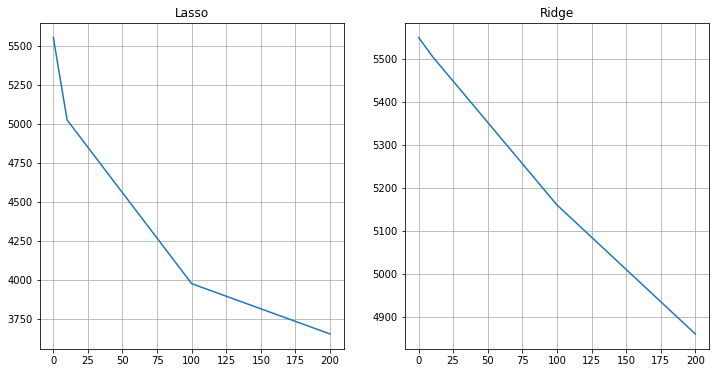

In [31]:
norms_l1, norms_l2 = [], []
alphas = (0.1, 1, 10, 100, 200)

for alpha in alphas:
    lrm_l1 = Lasso(alpha).fit(x_train_std, y_train)
    lrm_l2 = Ridge(alpha).fit(x_train_std, y_train)
    norms_l1.append(np.linalg.norm(lrm_l1.coef_))
    norms_l2.append(np.linalg.norm(lrm_l2.coef_))
    
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(alphas, np.array(norms_l1))
axes[1].plot(alphas, np.array(norms_l2))

axes[0].grid()
axes[1].grid()
axes[0].set_title('Lasso')
axes[1].set_title('Ridge')

plt.show()

_Похоже, что Lasso (L1-регуляризация) уменьшает веса агрессивнее, чем Ridge (L2-регуляризация)._

**Задача 3.11 (0.5 балла)** 
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке. 

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`. 

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество. 

In [32]:
from sklearn.linear_model import LassoCV

lrm_l1_cv = LassoCV(alphas=alphas, cv=5).fit(x_train_std, y_train)
pd.DataFrame(lrm_l1_cv.mse_path_.mean(axis=1), columns=['MMSE'],
             index=pd.Index(lrm_l1_cv.alphas_, name='alpha')).sort_values('MMSE')

C:\Users\pepsiman\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 499002730.3090439, tolerance: 48476565.46527788
  model = cd_fast.enet_coordinate_descent_gram(


MMSE
alpha              
1.0    1.293681e+06
0.1    1.295600e+06
10.0   1.304386e+06
100.0  1.546280e+06
200.0  1.969076e+06

_$\alpha = 1$ справилось лучше всех_

**Задача 3.12 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [33]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=1).fit(x_train_std, y_train)
get_coef_frame(model)

carat            x  clarity_SI2  clarity_I1     color_J  \
coef       5292.355926 -1057.146202  -581.952401 -500.712378 -416.666793   
abs. coef  5292.355926  1057.146202   581.952401  500.712378  416.666793   

              color_I  clarity_SI1  clarity_VVS2  clarity_IF  clarity_VVS1  \
coef      -291.248361  -251.396264    200.267577  200.011451    192.087171   
abs. coef  291.248361   251.396264    200.267577  200.011451    192.087171   

              color_H     color_D    cut_Fair  clarity_VS1     color_E  \
coef      -179.684332  163.994062 -131.510814   113.804669  107.725663   
abs. coef  179.684332  163.994062  131.510814   113.804669  107.725663   

               depth    color_F      table   cut_Good          z  cut_Ideal  \
coef      -86.839987  85.245889 -59.035308 -51.211156 -35.456798  34.465779   
abs. coef  86.839987  85.245889  59.035308  51.211156  35.456798  34.465779   

           cut_Very Good         y  cut_Premium  color_G  clarity_VS2  
coef          -12.731587 -4.229951          0.0     -0.0         -0.0  
abs. coef      12.731587  4.229951          0.0      0.0          0.0

_Наиболее информативным для предсказания цен на бриллианты признаком оказалась масса бриллианта в каратах.  
Похоже, что драгоценный материал сам по себе ценится сильно выше, чем работа ювелира._

**Задача 3.13 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [34]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print('Train MSE:', mean_squared_error(y_train, y_train_pred))
print('Train R2:', r2_score(y_train, y_train_pred))

print('Test MSE:', mean_squared_error(y_test, y_test_pred))
print('Test R2:', r2_score(y_test, y_test_pred))

Train MSE: 126373368.38452026
Train R2: -6.873218693217073
Test MSE: 125201621.87821886
Test R2: -7.02782226482776


_MSE модели Lasso-регресси оказалась в 100 раз больше, чем у обычной модели линейной регрессии,  
так что в данном случае я бы выбрал простую линейную регрессию._